#  Evaluations - General

In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import re
from omnetpp.scave import results, chart, utils
%matplotlib inline  

In [2]:
config_vec = "General-*.vec"
config_sca = "General-*.sca"

pre = "General_" # prefix for saved files

read_data_from_results = True

## Max Latencies

### Function definitions

In [7]:
def get_device(module):
    return module.split(".")[1]

def get_streamId(module, df):
    # assumning that streamIds are deterministic
    attrname = "*." + module.split(".")[1] + "." + module.split(".")[2] + ".display-name"
    attrval = df.loc[df['attrname'] == attrname,'attrvalue']
    try:
        return attrval.to_list()[0].split(" ")[0]
    except:
        return " "

def streamencodings(df):
    df_notna = df[df['attrname'].notna()]
    all_encodings = df_notna.loc[df_notna['attrname'].str.contains(".bridging.streamCoder.encoder.mapping")]
    # build a single json file based on streamname as key
    encodings = dict()
    for idx, row in all_encodings.iterrows():
        dev = row['attrname']
        encoding_str = row['attrvalue']
        encoding = re.findall(r'\{([^}]*)\}', encoding_str)
        for item in encoding:
            enc = item.split(",")  
            for e in enc:
                if "stream" in e:
                    stream = re.findall('"([^"]*)"', e)[0]
                elif "pcp" in e:
                    pcp = re.findall(r'\d+', e)[0]
                elif "vlan" in e:
                    vlan = re.findall(r'\d+', e)[0]
            # add infos to stream encoding
            if stream in encodings.keys():
                if pcp not in encodings[stream]['pcp']:
                    encodings[stream]['pcp'].append(pcp)
                if vlan not in encodings[stream]['vlan']:
                    encodings[stream]['vlan'].append(vlan)
                if dev not in encodings[stream]['dev']:
                    encodings[stream]['dev'].append(dev)
            else:
                encodings[stream] = {'pcp' : [pcp],
                                    'vlan' : [vlan],
                                    'dev' : [dev]}
    return encodings
        
def set_streamId(name): # streamnames are only sometimes deterministic, these are the special cases
    if "_" in name: # CAN
        return "SControl"
    if name == "SReset": # a single stream that is not formatted the same
        return "SControl"
    if name == " ": # Tcp-Stream
        return "SEtsiCamOut"
    
    return name

def get_pcp(streamname, device , df):
    if "zonalController" in device:
        attrname = "*.zonalController*.bridging.streamCoder.decoder.mapping"
    else:
        attrname = "*." + device + ".bridging.streamCoder.decoder.mapping"
    
    try:
        decoding_str = df.loc[df['attrname']==attrname, 'attrvalue'].to_list()[0]
        decoding = re.findall(r'\{([^}]*)\}', decoding_str)
        # get pcp for the stream from the table
        for item in decoding:
            if (streamname + "\"") in item:
                return item.split(",")[1][-1:]
    except:
        return " "

def get_pcp_from_encodings(streamname, encodings):
    try:
        return encodings[streamname]['pcp'][0]
    except:
        return " "
        

def max_delay(vals):
    try:
        return vals.max()
    except Exception as e:
        print(e)
        return "ERROR"


def extract_e2edelay(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    res['streamname'] = res.apply(lambda row: get_streamId(row['module'], df), axis=1)
    res['streamname-Control'] = res.apply(lambda row: set_streamId(row['streamname']), axis=1)
    encodings  = streamencodings(df)
    res['pcp'] = res.apply(lambda row: get_pcp_from_encodings(row['streamname-Control'], encodings), axis=1)
    res['max e2e delay'] = res.apply(lambda row: max_delay(row['vecvalue']), axis=1)
    
    return res

### Evaluate latencies and jitter

In [76]:
# read results
if read_data_from_results:
    res = results.read_result_files(filenames = config_vec,
                                filter_expression = "name =~ meanBitLifeTimePerPacket:vector")
    latencies = extract_e2edelay(res)
    latencies.to_pickle(pre+"latencies_data")
else:
    latencies = pd.read_pickle(pre+"latencies_data")

In [37]:
latency_jitter_by_priority = []
for prio, group in latencies.groupby('pcp'):
    sorted = group.sort_values('max e2e delay', ascending = False)
    
    max_latency = group['max e2e delay'].max()
    min_latency = group['max e2e delay'].min()
    jitter = max_latency - min_latency

    max_stream = group.loc[group['max e2e delay'] == max_latency, 'module'].to_list()

    latency_jitter_by_priority.append({"pcp": prio,
                                       "max latency [s]": max_latency,
                                       "min latency [s]": min_latency,
                                       "jitter [s]": jitter,
                                       "stream with max latency": max_stream
                                      })

df_latency_prio = pd.DataFrame(latency_jitter_by_priority)

df_latency_prio.to_csv(pre+"latency_by_prio.csv", index=False)
df_latency_prio


    
    

,pcp,max latency [s],min latency [s],jitter [s],stream with max latency
0,2,0.000224,0.000038,0.000186,[Car.connectivityGateway.app[0].connection[0]....
1,4,0.000268,0.000007,0.000261,[Car.zonalControllerRearRight.app[91].sink]
2,5,0.000157,0.000064,0.000094,[Car.adas.app[2].sink]
3,6,0.000099,0.000033,0.000066,[Car.zonalControllerFrontLeft.app[5].sink]


### Latencies Prio 6, per stream

In [38]:
l_p6  = latencies.loc[latencies['pcp'] == "6"].copy()

In [39]:
l_p6['min e2e delay'] = l_p6.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p6['jitter'] = l_p6.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

In [40]:
l_p6_streams = l_p6[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p6_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p6_streams.to_csv(pre+"latencies_prio6.csv")

In [41]:
l_p6_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3552,Car.zonalControllerFrontLeft.app[5].sink,zonalControllerFrontLeft,SAutoSteer,0.000099,0.000096,0.000003
3559,Car.zonalControllerRearRight.app[2].sink,zonalControllerRearRight,SManualSteer,0.000099,0.000096,0.000003
3538,Car.zonalControllerFrontLeft.app[4].sink,zonalControllerFrontLeft,SAutoBrake,0.000097,0.000094,0.000003
3545,Car.zonalControllerRearRight.app[1].sink,zonalControllerRearRight,SManualBrake,0.000097,0.000094,0.000003
3524,Car.zonalControllerFrontLeft.app[3].sink,zonalControllerFrontLeft,SAutoThrottle,0.000095,0.000092,0.000003
3531,Car.zonalControllerRearRight.app[0].sink,zonalControllerRearRight,SManualThrottle,0.000095,0.000092,0.000003
3496,Car.zonalControllerFrontRight.app[2].sink,zonalControllerFrontRight,SManualSteer,0.000069,0.000065,0.000004
3503,Car.zonalControllerRearLeft.app[2].sink,zonalControllerRearLeft,SManualSteer,0.000069,0.000065,0.000004
3510,Car.zonalControllerFrontRight.app[5].sink,zonalControllerFrontRight,SAutoSteer,0.000069,0.000065,0.000004
3517,Car.zonalControllerRearLeft.app[5].sink,zonalControllerRearLeft,SAutoSteer,0.000069,0.000065,0.000003


### Latencies Prio 5, per stream

In [42]:
l_p5  = latencies.loc[latencies['pcp'] == "5"].copy()

l_p5['min e2e delay'] = l_p5.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p5['jitter'] = l_p5.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

l_p5_streams = l_p5[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p5_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p5_streams.to_csv(pre+"latencies_prio5.csv")

l_p5_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3412,Car.adas.app[2].sink,adas,SLidarFrontLeft,0.000157,0.000074,0.000083
3405,Car.adas.app[4].sink,adas,SLidarRearLeft,0.000129,0.000047,0.000082
3398,Car.adas.app[3].sink,adas,SLidarFrontRight,0.000128,0.000046,0.000081
3384,Car.adas.app[1].sink,adas,SVideoRear,0.000123,0.000034,0.000089
3377,Car.adas.app[0].sink,adas,SVideoFront,0.000121,0.000034,0.000087
3391,Car.adas.app[5].sink,adas,SLidarRearRight,0.000064,0.000029,0.000034


### Latencies Prio 4, per stream

In [43]:
l_p4  = latencies.loc[latencies['pcp'] == "4"].copy()

l_p4['min e2e delay'] = l_p4.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p4['jitter'] = l_p4.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

l_p4_streams = l_p4[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p4_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p4_streams.to_csv(pre+"latencies_prio4.csv")

l_p4_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3671,Car.zonalControllerRearRight.app[91].sink,zonalControllerRearRight,SAirbag_03,0.000268,0.000006,0.000262
3664,Car.zonalControllerRearRight.app[89].sink,zonalControllerRearRight,SAirbag_01,0.000267,0.000005,0.000262
3902,Car.zonalControllerRearRight.app[112].sink,zonalControllerRearRight,SGetriebe_06,0.000267,0.000010,0.000257
3895,Car.zonalControllerRearRight.app[87].sink,zonalControllerRearRight,SACC_10,0.000266,0.000009,0.000257
3888,Car.zonalControllerRearRight.app[86].sink,zonalControllerRearRight,SACC_07,0.000265,0.000008,0.000258
...,...,...,...,...,...,...
6358,Car.infotainment.app[22].sink,infotainment,SEinheiten_01,0.000015,0.000005,0.000010
5000,Car.zonalControllerFrontLeft.app[137].sink,zonalControllerFrontLeft,SNavPos_01,0.000015,0.000003,0.000012
4979,Car.zonalControllerFrontLeft.app[136].sink,zonalControllerFrontLeft,SNavData_02,0.000013,0.000002,0.000012
4965,Car.zonalControllerFrontLeft.app[135].sink,zonalControllerFrontLeft,SNavData_01,0.000012,0.000001,0.000011


### latencies per prio

In [81]:
latencies_extend = latencies.copy()
latencies_extend['min e2e delay'] = latencies_extend.apply(lambda row: row['vecvalue'].min(), axis=1)
latencies_extend['jitter'] = latencies_extend.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

lat = []
for prio, group in latencies_extend.groupby('pcp'):
    max_delay = group['max e2e delay'].max()
    max_d_stream = group.loc[group['max e2e delay'] == max_delay, 'module'].to_list()
    max_jitter = group['jitter'].max()
    max_j_stream = group.loc[group['jitter'] == max_jitter, 'module'].to_list()

    lat.append({"pcp": prio,
               "max latency [s]": max_delay,
               "streams with max latency": max_d_stream,
               "max jitter [s]": max_jitter,
               "streams with max jitter": max_j_stream})

latencies_pcp = pd.DataFrame(lat)


In [83]:
latencies_pcp.to_csv(pre+"latency_jitter_pcp.csv", index=False)

In [84]:
latencies_pcp

,pcp,max latency [s],streams with max latency,max jitter [s],streams with max jitter
0,2,0.000224,[Car.connectivityGateway.app[0].connection[0]....,0.000221,[Car.connectivityGateway.app[0].connection[0]....
1,4,0.000268,[Car.zonalControllerRearRight.app[91].sink],0.000262,"[Car.zonalControllerRearRight.app[89].sink, Ca..."
2,5,0.000157,[Car.adas.app[2].sink],0.000089,[Car.adas.app[1].sink]
3,6,0.000099,[Car.zonalControllerFrontLeft.app[5].sink],0.000004,"[Car.zonalControllerFrontRight.app[0].sink, Ca..."


### Evaluate if apps receive data

In [44]:
def get_appno(module):
    num = re.findall(r'\[.*?\]', module)[0]
    nums = re.findall(r'\d+', num)
    if ".." in num:
        r_nums = []
        for i in range (int(nums[0]), int(nums[1])+1):
            r_nums.append(i)
        return r_nums
    else:
        return nums

In [45]:
# find all configured sinks
df_sinkapps = res.loc[res['attrvalue'].isin(["UdpSinkApp", "TcpClientApp", "TcpServerApp"]), ['attrname', 'attrvalue']]

configured_sinks = []
for idx, row in df_sinkapps.iterrows():
    if ".." in row['attrname']: # config for multiple apps
        nums = get_appno(row['attrname'])
        for n in nums:
            sink = get_device(row['attrname']) + ".app[" + str(n) + "]"
            configured_sinks.append(sink)
    else:
        sink = get_device(row['attrname']) + ".app[" + re.findall(r'\d+', row['attrname'])[0] + "]"
        configured_sinks.append(sink)


In [46]:
# find all sinks that received at least one packet that is counted towards latency-results
sinks_receiving_data = latencies['module'].to_list()

# and bring them in same format as configured_strings
sinks_receiving_data_formatted = []
for sink in sinks_receiving_data:
    formatted = sink.split(".")[1] + "." + sink.split(".")[2]
    sinks_receiving_data_formatted.append(formatted)


In [47]:
# compare the lists

# only configured
diff_conf = []
for s in configured_sinks:
    if s not in sinks_receiving_data_formatted:
        diff_conf.append(s)

diff_conf

# all of these apps do have a 'dropped data rate', if you check them by hand, is this wanted?

[]

In [48]:
# only in results
diff_res = []
for s in sinks_receiving_data_formatted:
    if s not in configured_sinks:
        diff_res.append(s)

diff_res

[]

## Queueing

### Function definitions

In [4]:
### Function definitions
def get_devicePort(module):
    split = module.split(".")
    return split[1] + "." + split[2]

def get_queueNo(module):
    split = module.split(".")
    if len(split) < 6:
        return "all"
    else:
        return split[5]


def extract_maxq(df):
    res = df[['runID', 'module', 'value']].dropna()
    res.sort_values(by='value', ascending=False, inplace=True)
#res_maxq['device'] = res_maxq.apply(lambda row: get_device(row['module']), axis=1)
    res['device+port'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['queue'] = res.apply(lambda row: get_queueNo(row['module']), axis=1)
    res = res[['runID','device+port', 'queue', 'value']]
    return res

### Max queuelengths

In [50]:
# read results
if read_data_from_results:
    res_q = results.read_result_files(filenames = config_sca,
                                filter_expression = "module =~ *.eth[*].macLayer.queue* AND name =~ queueLength:max")
    max_q = extract_maxq(res_q)
    max_q.to_pickle(pre+"queues_data")
else:
    max_q = pd.read_pickle(pre+"queues_data")

In [51]:
# queues by priority

qs = []
for q, group in max_q.groupby('queue'):
    max = group['value'].max()
    port = group.loc[group['value'] == max]
    ports = port['device+port'].to_list()
    if q == "all":
       qs.append({"prio": "all",
                "max": max,
                 "port": ports}) 
    else:
        prio = re.findall(r'\d+', q)[0]
        qs.append({"prio": prio,
                   "max": max,
                   "port": ports})

df_qs = pd.DataFrame(qs)

df_qs
    

,prio,max,port
0,all,185.0,[zonalControllerRearRight.eth[0]]
1,0,131.0,[zonalControllerFrontLeft.eth[0]]
2,2,1.0,"[connectivityGateway.eth[0], switchRearRight.e..."
3,4,83.0,[switchFrontRight.eth[1]]
4,5,7.0,[switchRearRight.eth[2]]
5,6,6.0,"[switchRearLeft.eth[4], switchRearRight.eth[3]..."
6,7,4.0,"[switchRearRight.eth[2], switchFrontLeft.eth[5..."


### Queues over time

In [52]:
def extract_data_qlen(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device+port'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['queue'] = res.apply(lambda row: get_queueNo(row['module']), axis=1)
    res['max length'] = res.apply(lambda row: row['vecvalue'].max(), axis=1)
    return res

def set_curmax(vec):
    max = 0
    res = []
    for v in vec:
        if v > max:
            max = v
            res.append(v)
        else:
            res.append(max)
    return res

def get_maxtime(time, vec, max):
    m_idx = [i for i, v in enumerate(vec) if v == max]
    return time[m_idx]

In [53]:
# read results
if read_data_from_results:
    res_qv = results.read_result_files(filenames = config_vec,
                                filter_expression = "module =~ *macLayer.queue* AND name =~ queueLength:vector")
    qvs = extract_data_qlen(res_qv)
    qvs.to_pickle(pre+"queues_vec_data")
else:
    qvs = pd.read_pickle(pre+"queues_vec_data")

#### classify behaviour of streams (somehow)...

In [54]:
qvs['current max'] = qvs.apply(lambda row: set_curmax(row['vecvalue']), axis=1)
qvs['times of max'] = qvs.apply(lambda row: get_maxtime(row['vectime'], row['vecvalue'], row['max length']), axis=1)
qvs['latest time of max'] = qvs.apply(lambda row: row['times of max'].max(), axis=1)
qvs['number of max'] = qvs.apply(lambda row: len(row['times of max']), axis=1)

In [55]:
# Streams that reach their max in the last second (but max reach it before then too)
qvs_lastsec = qvs[['device+port', 'queue', 'max length']].loc[qvs['latest time of max'] > 9.0].sort_values('max length', ascending=False)
qvs_lastsec.loc[qvs_lastsec['queue'] != "all"]

,device+port,queue,max length
3898,switchFrontRight.eth[1],queue[4],83.0
3749,zonalControllerRearRight.eth[0],queue[4],79.0
3733,zonalControllerFrontRight.eth[0],queue[4],62.0
3938,switchFrontLeft.eth[4],queue[4],49.0
3961,switchFrontRight.eth[4],queue[4],47.0
...,...,...,...
3821,adas.eth[0],queue[2],1.0
4198,switchRearRight.eth[1],queue[7],1.0
3789,cameraFront.eth[0],queue[5],1.0
4022,switchRearRight.eth[1],queue[2],1.0


In [56]:
# streams that reach max less than 5 times during runtime
qvs_fewmax =qvs[['device+port', 'queue', 'max length', 'number of max', 'times of max']].loc[qvs['number of max'] < 5].sort_values('max length', ascending=False)
qvs_fewmax.loc[qvs_fewmax['queue'] != "all"]

,device+port,queue,max length,number of max,times of max
3677,zonalControllerFrontLeft.eth[0],queue[0],131.0,1,[0.0]
3685,zonalControllerFrontRight.eth[0],queue[0],120.0,1,[0.0]
3701,zonalControllerRearRight.eth[0],queue[0],105.0,1,[0.0]
3898,switchFrontRight.eth[1],queue[4],83.0,2,"[49.99957093541, 81.999253540044]"
4357,switchFrontRight.eth[1],queue[0],53.0,1,[0.000128552944]
4214,switchFrontLeft.eth[4],queue[0],49.0,1,[9.9297999e-05]
3693,zonalControllerRearLeft.eth[0],queue[0],46.0,1,[0.0]
3930,switchFrontLeft.eth[0],queue[4],40.0,1,[17.99985538765]
3709,infotainment.eth[0],queue[0],39.0,1,[0.0]
3906,switchRearLeft.eth[1],queue[4],34.0,4,"[38.999670644067, 38.999671316067, 38.99967198..."


In [57]:
prio6_qvs = qvs[['device+port', 'queue', 'max length', 'number of max', 'times of max']].loc[qvs['module'] == "Car.switchRearLeft.eth[4].macLayer.queue.queue[6]"]
for t in prio6_qvs['times of max']:
    print (t)

[3.38420000e-05 9.58420000e-05 1.03384200e-03 ... 1.19998924e+02
 1.19999862e+02 1.19999924e+02]


#### plot largest 5 queues per prio

In [58]:
plts_queues = []
for prio, g in qvs.groupby('queue'):
    plts_queues.append(g.sort_values('max length', ascending=False).head(5))

df_plt_q = pd.concat(plts_queues)

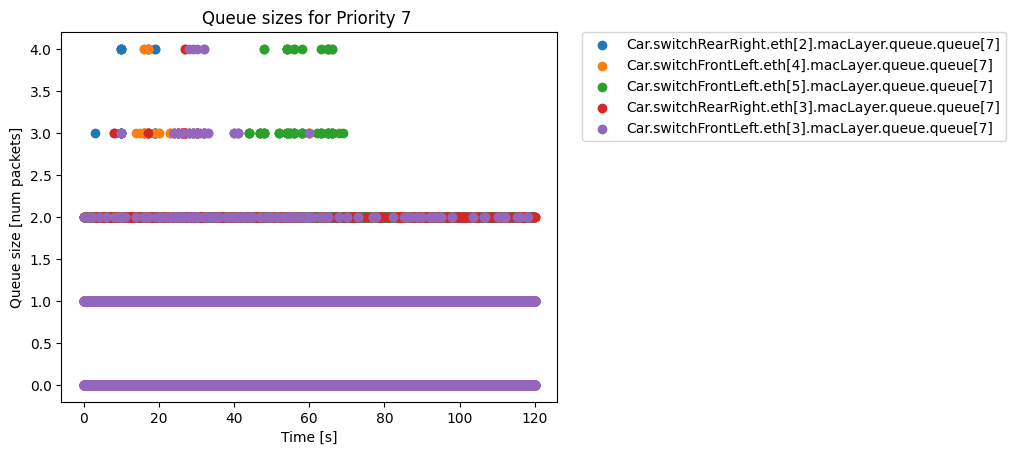

In [59]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[7]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 7 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

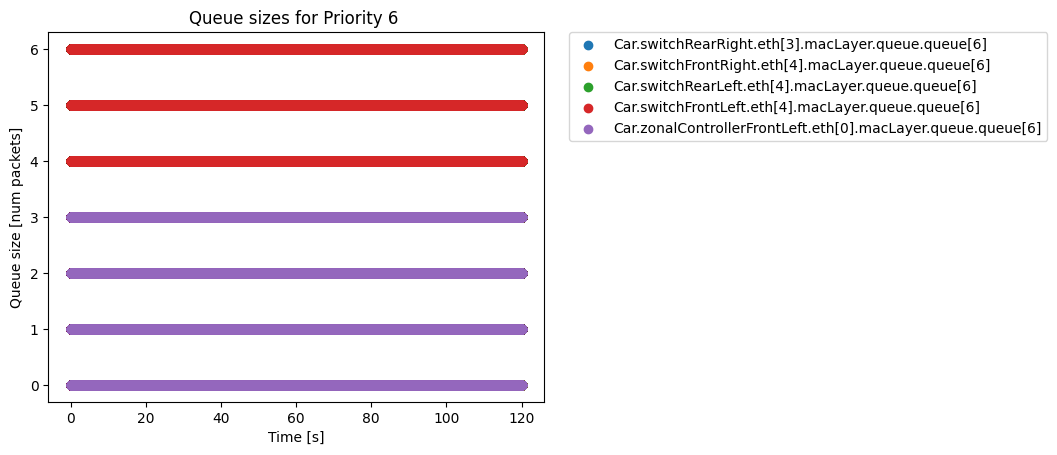

In [60]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[6]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 6 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

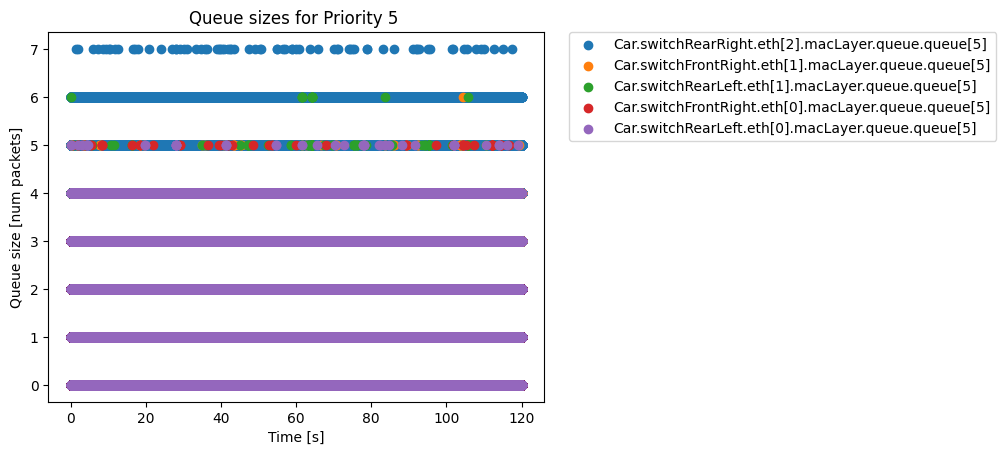

In [61]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[5]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 5 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

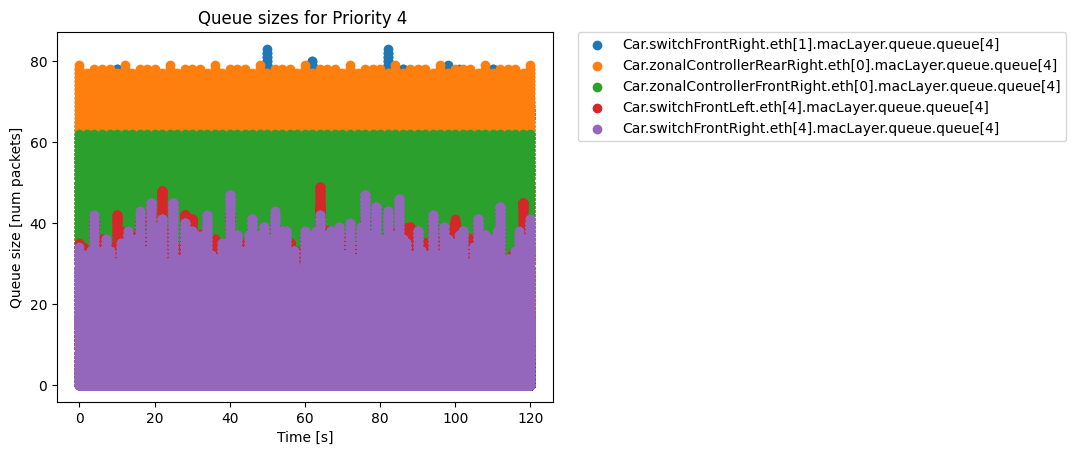

In [62]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[4]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 4 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

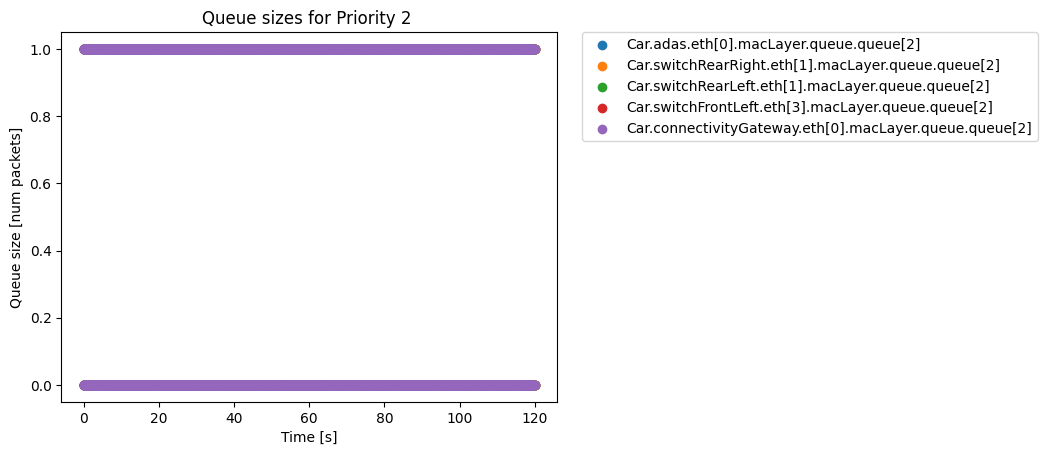

In [63]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[2]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 2 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

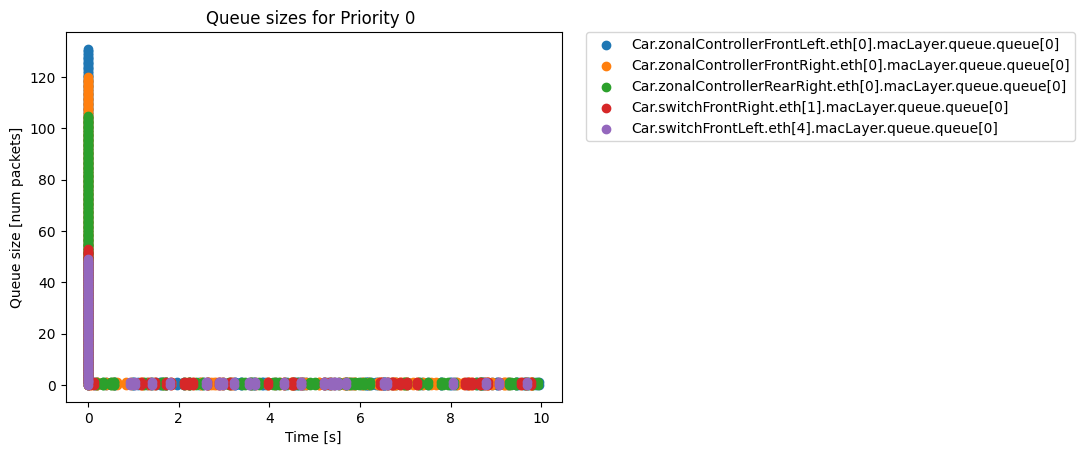

In [64]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[0]"].iterrows():
    plt.scatter(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 0 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Packets sent and received

In [52]:
res_sources = results.read_result_files(filenames = config_sca,
                                 filter_expression = "module=~ *.io AND name =~ packetSent:count")

In [53]:
res_sinks = results.read_result_files(filenames = config_sca,
                                 filter_expression = "module =~ *.io AND name =~ packetReceived:count")

In [68]:

def sourceorsink(attrname):
    if "localPort" in attrname:
        return "sink"
    elif "destPort" in attrname:
        return "source"
    elif "connectPort" in attrname: # this is TCP client
        return "source" 

def appports(df):
    r = df[['attrname', 'attrvalue']].dropna()
    info = r.loc[r['attrname'].str.contains("localPort|destPort|connectPort")].copy()
    #d = df.loc[df['attrname'].str.contains("destPort"), ['attrname', 'attrvalue']].copy()
    #c = df.loc[df['attrname'].str.contains("connectPort"), ['attrname', 'attrvalue']].copy()
    #info = pd.concat([l,d])
    info['deviceapp'] = info.apply(lambda row: get_devicePort(row['attrname']), axis=1)
    info['sourcesink'] = info.apply(lambda row: sourceorsink(row['attrname']), axis=1)
    info['port'] = info['attrvalue']
    
    return dict(zip(info.deviceapp, info.port))

def extract_numpacks(df):
    res = df[['runID', 'module', 'value']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    res['device+app'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['streamname'] = res.apply(lambda row: get_streamId(row['module'], df), axis=1)
    # get the application port (local and/or destination) to match apps later
    app_ports = appports(df)
    res['app-port'] = res.apply(lambda row: app_ports[row['device+app']], axis=1)
    return res


In [69]:
# TODO: identify streams and compare
d_sources = extract_numpacks(res_sources)
d_sources['srcsink'] = "source"
d_sinks = extract_numpacks(res_sinks)
d_sinks['srcsink'] = "sink"

numpack = pd.concat([d_sources, d_sinks])

In [70]:
# sort everything into stream - num at source - [num at sinks]
by_sink = []
for appport, group in d_sinks.groupby('app-port'):
    src = d_sources.loc[d_sources['app-port'] == appport]
    srcapp = src['device+app'].to_list()[0]
    srcdvc = src['device'].to_list()[0]
    srcpcks = src['value'].to_list()[0]
    for idx, row in group.iterrows():
        by_sink.append({ "app-port": appport,
                        "stream name": row['streamname'],
                        "source app": srcapp,
                        #"source device": srcdvc,
                        "destination app": row['device+app'],
                        #"destination device": row['device'],
                        "packets sent [count]": srcpcks,
                        "packets received [count]": row['value'],
                        "packets difference": srcpcks - row['value']})

packet_diff = pd.DataFrame(by_sink)
            

In [71]:
packet_diff.sort_values('packets difference', ascending=False)

,app-port,stream name,source app,destination app,packets sent [count],packets received [count],packets difference
6,1111,SVideoFront,cameraFront.app[0],adas.app[0],1845438.0,1845437.0,1.0
7,1112,SVideoRear,cameraRear.app[0],adas.app[1],1845855.0,1845854.0,1.0
0,1000,SManualThrottle,zonalControllerFrontLeft.app[0],zonalControllerFrontRight.app[0],120002.0,120002.0,0.0
308,6020,SESP_20,zonalControllerRearRight.app[26],zonalControllerFrontLeft.app[75],121.0,121.0,0.0
320,6025,SGetriebe_11,zonalControllerRearRight.app[31],zonalControllerFrontLeft.app[82],2401.0,2401.0,0.0
...,...,...,...,...,...,...,...
153,4015,SKN_HDSG,zonalControllerFrontRight.app[21],zonalControllerFrontLeft.app[104],241.0,241.0,0.0
152,4014,SKN_ELV,zonalControllerFrontRight.app[20],zonalControllerRearRight.app[118],241.0,241.0,0.0
151,4014,SKN_ELV,zonalControllerFrontRight.app[20],zonalControllerRearLeft.app[34],241.0,241.0,0.0
150,4014,SKN_ELV,zonalControllerFrontRight.app[20],zonalControllerFrontLeft.app[101],241.0,241.0,0.0


In [72]:
packet_diff.to_csv(pre+"num_packets.csv", index=False)

## Send cycle

In [3]:
res_cycle = results.read_result_files(filenames = config_vec,
                                 filter_expression = "module=~ *.source AND name =~ packetLengths:vector")

In [83]:
def get_cycle(vec):
    cycle_vec = []
    prev = 0
    for i,v in enumerate(vec):
        if i == 0:
            prev = i
        else:
            cycle_vec.append(v-prev)
            prev=v
        
    return cycle_vec


def get_streamId_fromsrc(module, df):
    attrname = "*." + module.split(".")[1] + "." + module.split(".")[2] + ".source.packetNameFormat"  
    attrval = df.loc[df['attrname'] == attrname,'attrvalue']

    if "connectivityGateway.app[0]" in attrname: # TCP Server
        return "SEtsiCam"
    
    try:
        format = attrval.to_list()[0]
        # find the name
        s1 = format.split("-")[1]
        return s1[1:]
    except:
        return " "

def extract_cycle(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    res['device+app'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['streamname'] = res.apply(lambda row: get_streamId_fromsrc(row['module'], df), axis=1)
    res['streamname-Control'] = res.apply(lambda row: set_streamId(row['streamname']), axis=1)
    encodings  = streamencodings(df)
    res['pcp'] = res.apply(lambda row: get_pcp_from_encodings(row['streamname-Control'], encodings), axis=1)
    res['cycletime'] = res.apply(lambda row: get_cycle(row['vectime']), axis=1)
    res['maxcycle'] = res.apply(lambda row: max(row['cycletime']), axis=1)#res.apply(lambda row: row['cycletime'].max(), axis=1)
    res['mincycle'] = res.apply(lambda row: min(row['cycletime']), axis=1)
    res['cyclejitter'] = res.apply(lambda row: row['maxcycle'] - row['mincycle'], axis=1)
    res['cyclemean'] = res.apply(lambda row: np.mean(row['cycletime']), axis=1 )
    
    return res

In [84]:
cycle = extract_cycle(res_cycle)

In [86]:
cycle[['module','streamname','pcp','maxcycle', 'mincycle', 'cyclejitter', 'cyclemean']].to_cst

,module,streamname,pcp,maxcycle,mincycle,cyclejitter,cyclemean
3377,Car.zonalControllerFrontLeft.app[0].source,SManualThrottle,6,0.001001,0.000999,0.000003,0.001000
3383,Car.zonalControllerFrontLeft.app[1].source,SManualBrake,6,0.001001,0.000999,0.000003,0.001000
3389,Car.zonalControllerFrontLeft.app[2].source,SManualSteer,6,0.001001,0.000999,0.000003,0.001000
3395,Car.zonalControllerFrontLeft.app[6].source,SACC_02,4,0.060001,0.059997,0.000003,0.059999
3401,Car.zonalControllerFrontLeft.app[7].source,SACC_06,4,0.020001,0.019998,0.000003,0.020000
...,...,...,...,...,...,...,...
4661,Car.adas.app[6].source,SAutoThrottle,6,0.001002,0.000998,0.000003,0.001000
4667,Car.adas.app[7].source,SAutoBrake,6,0.001002,0.000998,0.000003,0.001000
4673,Car.adas.app[8].source,SAutoSteer,6,0.001002,0.000998,0.000003,0.001000
4679,Car.adas.app[9].source,SEtsiCamOut,2,0.998005,0.101759,0.896246,0.594297


In [98]:
cycle[['module','streamname','pcp','maxcycle', 'mincycle', 'cyclejitter', 'cyclemean']].sort_values('cyclemean', ascending=False)

,module,streamname,pcp,maxcycle,mincycle,cyclejitter,cyclemean
4295,Car.zonalControllerRearRight.app[44].source,SKlima_06,4,1.999981,1.999980,1.376033e-06,1.999980
4007,Car.zonalControllerFrontRight.app[65].source,SWIV_01,4,1.999980,1.999980,1.159961e-10,1.999980
4187,Car.zonalControllerRearRight.app[26].source,SESP_20,4,0.999991,0.999990,1.375982e-06,0.999990
4211,Car.zonalControllerRearRight.app[30].source,SGateway_80,4,0.999991,0.999990,1.375982e-06,0.999990
4523,Car.zonalControllerRearRight.app[82].source,SWischer_01,4,0.999991,0.999990,1.375982e-06,0.999990
...,...,...,...,...,...,...,...
4541,Car.lidarFrontLeft.app[0].source,SLidarFrontLeft,5,0.000152,0.000148,4.446596e-06,0.000150
4547,Car.lidarFrontRight.app[0].source,SLidarFrontRight,5,0.000151,0.000149,1.987271e-06,0.000150
4553,Car.lidarRearLeft.app[0].source,SLidarRearLeft,5,0.000150,0.000149,1.220775e-06,0.000150
4565,Car.cameraFront.app[0].source,SVideoFront,5,0.000100,0.000029,7.068143e-05,0.000065


In [96]:
cycle.to_csv(pre+"cycle_times.csv")

In [94]:
cycle['cyclemean'].mean()

0.28659844165157544